# A toy model of ensemble epistasis
Brandon Schlomann, 8/19/2018

Here's a notebook to accompany the pdf notes.  It's a work in progress.  I focus here on the case of just 2 perturbations that only affect the probability of each state, not the phenotypes directly.  The perturbations are taken to be independent draws from a probability distribution and then averaged over.  Any epistasis that emerges is therefore due to the ensemble.  


In [114]:
""" Imports """

import numpy as np
import matplotlib.pyplot as plt
import math

The next cell is the main function.  It has the following inputs and outputs. 

Inputs: 

1. original_probabilities - numpy array of normalized starting probabilities for each state, (1 x number of states)
        
2. original_phenotypes - numpy array of phenotype values, (1 x number of states)

3. num_mutations - int, number of mutations/perturbations

4. num_trials - int, number of independent replicates of experiment

Outputs:

1. true_full_mutant_phenotypes - numpy array (1 x num_trials), given an ordered list of mutations/perturbations, this is the result of applying them all.

2. additive_predictions - numpy array (1 x num_trials), predictions of full mutant phenotypes from an additive model

In [134]:
def random_ensemble_epistasis(original_probabilities, original_phenotypes, num_mutations, num_trials):

    if np.size(original_phenotypes) != np.size(original_probabilities):
        print('error: number of phenotypes not equal to number of probabilities')
        print(np.size(original_probabilities), np.size(original_phenotypes))

        return

    # number of states in system
    num_states = np.size(original_probabilities)

    # array for full mutant phenotype, i.e. if num_mutations = 3, a triple mutant
    full_mutant_phenotypes = np.zeros((num_trials, num_states))

    # array for full mutant probabilities of each state
    full_mutant_probabilities = np.zeros((num_trials, num_states))

    # array for all probabilities
    probabilities = np.repeat(np.repeat(np.reshape(original_probabilities, (1, num_states, 1)), num_trials, axis=2),num_mutations+1,axis=0)

    # draw probability perturbations from a gamma distribution and then normalize them
    mu_p = 1
    sig2_p = 1
    k = mu_p*mu_p/sig2_p/num_states
    theta = sig2_p/mu_p

    probability_perturbations = np.random.gamma(k, scale=theta, size=(num_mutations, num_states, num_trials))

    # normalize
    for n in range(np.shape(probability_perturbations)[0]):
        for t in range(np.shape(probability_perturbations)[2]):
            probability_perturbations[n, :, t] = probability_perturbations[n, :, t]/np.sum(probability_perturbations[n, :, t])

    # apply perturbations and normalize them.  simple average.
    probabilities[1:, :, :] += probability_perturbations
    probabilities[1:, :, :] *= .5
       
    # create a phenotypes array with replicas of original phenotypes to be used in calculation of averages.
    phenotypes = np.repeat(np.repeat(np.reshape(original_phenotypes, (1, num_states, 1)), num_trials, axis=2),num_mutations+1,axis=0)

    # compute single mutant phenotypes averaged over states by summing phenotypes*probablities.  reshape to convenient shape.
    ensemble_averaged_single_mutant_phenotypes = np.sum(probabilities*phenotypes, axis=1)
  
    # compute predicted full mutant phenotypes from additive model.
    # the first row of ensemble_averaged_single_mutant_phenotypes is the original phenotypes.
    # for each of the others, the additive prediction is the sum of the averages, subtracting out
    # appropriate numbers of the unperturbed phenotype.
    additive_predictions = np.sum(ensemble_averaged_single_mutant_phenotypes[1:, :], axis=0) - (num_mutations - 1)*ensemble_averaged_single_mutant_phenotypes[0,:]
    
    # true full mutant phenotypes
    #true_full_mutant_phenotypes_2 = np.copy(ensemble_averaged_single_mutant_phenotypes[0, :])
    fully_pertrubed_probabilities = np.copy(probabilities[0, :, :])

    for m in range(num_mutations):
        #true_full_mutant_phenotypes_2 += np.sum(probability_perturbations[m, :, :]*phenotypes[0,:,:],axis=0)
        #true_full_mutant_phenotypes_2 *= .5
        fully_pertrubed_probabilities += probability_perturbations[m, :, :]
        fully_pertrubed_probabilities *= .5
    
    true_full_mutant_phenotypes = np.reshape(np.sum(phenotypes[0, :, :]*fully_pertrubed_probabilities,axis=0),(1, num_trials))

    # only for num_mutations = 2
    if num_mutations == 2:
        analytic_predictions = .25*(ensemble_averaged_single_mutant_phenotypes[0, :] - np.mean(np.sum(probability_perturbations[0,:,:]*phenotypes[0,:,:],axis=0), axis=0))
        print('average % abs error from analytic prediction is ', 100*np.sum(np.abs(analytic_predictions-np.mean(true_full_mutant_phenotypes-additive_predictions)))/num_trials/np.abs(np.mean(true_full_mutant_phenotypes)))

    return true_full_mutant_phenotypes, additive_predictions







Next is a simple function for generating starting probabilities and phenotypes.  Probabilities are drawn from a gamma distribution, phenotypes from a gaussian distribution.

In [179]:
def generate_random_original_probabilities_and_phenotypes(num_states):

    mu_p = 1
    sig2_p = 1  # change this (the variance) to change the strength of the perturbations
    k = mu_p * mu_p / sig2_p / num_states
    theta = sig2_p / mu_p

    original_probabilities = np.random.gamma(k, scale=theta, size=(1, num_states))
    original_probabilities = original_probabilities/np.sum(original_probabilities)

    loc = 0
    scale = 1
    original_phenotypes = np.random.normal(loc=loc, scale=scale, size=(1, num_states))

    return original_probabilities, original_phenotypes


### Calculation 1: average pairwise epistasis

Here we consider just 2 perturbations and a variable number of states.  The perturbations only affect the probabilities of each state, not the phenotypes directly.  We draw perturbation parameters from probability distributions and average over them.  The goal is to compute the pairwise epistasis, defined as deviation from an additive model, for which the analytic solution is

\begin{equation}
\mathbb{E}\left[\langle \mathcal{O} \rangle_{12} - \langle \mathcal{O} \rangle^{\text{add}}_{12}\right]_{\alpha} = \frac{1}{4}\left(\langle \mathcal{O} \rangle_{0} - \mathbb{E}\left[\langle \mathcal{O} \rangle_1^{\alpha}\right]_{\alpha}\right).
\end{equation}

There is a lot of notation here (still figuring out the best system), refer to the pdf of notes for more details. In brief, $ \mathbb{E}\left[...\right]_{\alpha}$ means average over random draws of the $\alpha$s, and $\langle ... \rangle$  means average over the discrete probability distribution for the states.  Subscripts on the angled brackets refer to the probability distribution after single perturbation $n=0,1,2$. A superscript $\alpha$ means average with respect to the perturbing distribution.


In [198]:
ns = 10
num_states_arr = np.int16(np.logspace(0, 2, ns))
num_mutations = 2
num_trials = 10000

mean_epistasis_arr = np.zeros(ns)
original_probabilities, original_phenotypes = generate_random_original_probabilities_and_phenotypes(num_states_arr[-1])
original_mean_phenotype = np.sum(original_probabilities*original_phenotypes)

true_ph_arr = np.zeros((ns,num_trials))
add_ph_arr = np.zeros((ns,num_trials))

for n in range(ns):
    print("n = ",n+1, " of ", ns )
    
    these_original_probabilities = original_probabilities[:,0:(num_states_arr[n])]
    these_original_probabilities = these_original_probabilities/np.sum(these_original_probabilities)
    
    these_original_phenotypes = original_phenotypes[:,0:num_states_arr[n]]
    
    true_ph, add_ph = random_ensemble_epistasis(these_original_probabilities, these_original_phenotypes, num_mutations, num_trials)

    true_ph_arr[n,:] = true_ph
    
    add_ph_arr[n,:] = add_ph

    
    mean_epistasis_arr[n] = np.mean(true_ph - add_ph) / (np.sum(these_original_probabilities*these_original_phenotypes)-np.mean(these_original_phenotypes))
    
mean_epistasis_arr[mean_epistasis_arr!=mean_epistasis_arr] = 0   

n =  1  of  10
average % abs error from analytic prediction is  3.92326850313e-15
n =  2  of  10


/Users/brandonschlomann/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:28: RuntimeWarning: invalid value encountered in double_scalars


average % abs error from analytic prediction is  3.92326850313e-15
n =  3  of  10
average % abs error from analytic prediction is  3.02375905097e-14
n =  4  of  10
average % abs error from analytic prediction is  8.73158500985e-15
n =  5  of  10
average % abs error from analytic prediction is  3.7230298191e-15
n =  6  of  10
average % abs error from analytic prediction is  1.59501080964e-14
n =  7  of  10
average % abs error from analytic prediction is  5.59781825822e-14
n =  8  of  10
average % abs error from analytic prediction is  2.35925665859e-14
n =  9  of  10
average % abs error from analytic prediction is  1.95153151978e-14
n =  10  of  10
average % abs error from analytic prediction is  8.48803755785e-15


Plot the results.  The y axis, 'scaled pairwise epistasis', refers to the equation above, where the left hand side is scaled by everything on the right hand side except for the 1/4.

Regardless of the number of states, when averaged over random draws of the $\alpha$s and appropriately scaled, pairwise epistasis takes on the same value.

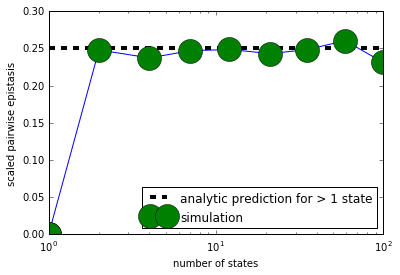

In [199]:
%matplotlib inline

ax1 = plt.semilogx(num_states_arr,.25*np.ones(np.shape(num_states_arr)),color='k',linewidth=4,linestyle='--',label='analytic prediction for > 1 state')
ax1 = plt.semilogx(num_states_arr, mean_epistasis_arr, marker='o', markersize=24, markerfacecolor='g',label='simulation')
plt.xlabel('number of states')
plt.ylabel('scaled pairwise epistasis')
plt.legend(loc=4)
plt.show()


# Calculation 2: the many states limit

The analytic calcuation in the pdf notes predicts that the probability distribution of pairwise epistasis coefficients limits to a Gaussian distriubtion as the number of states grows.  Just plotting the distributions shows that this is the case.


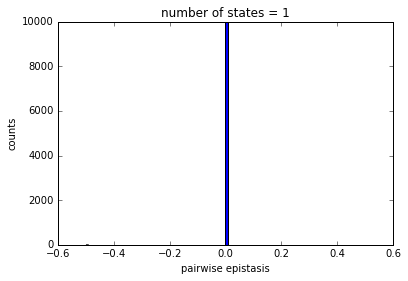

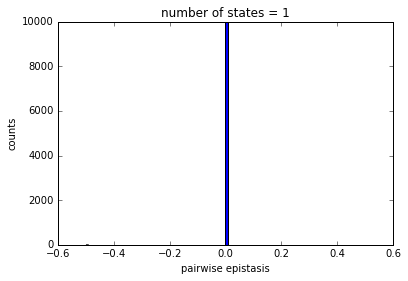

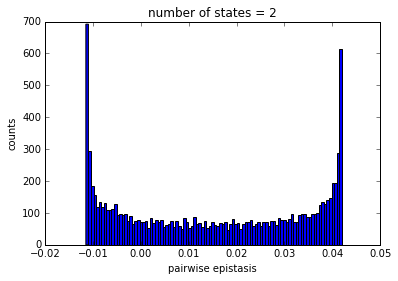

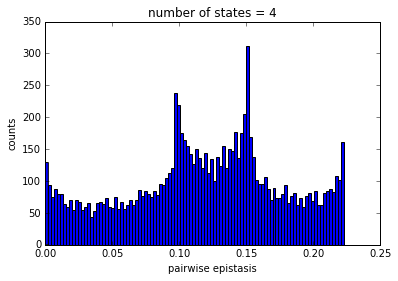

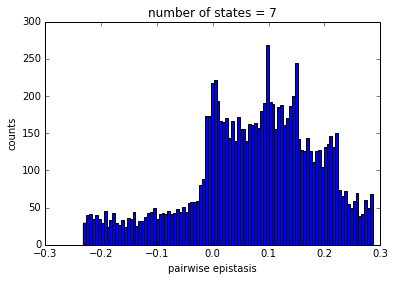

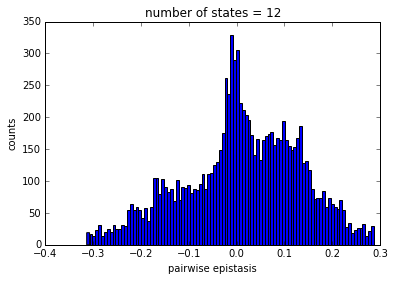

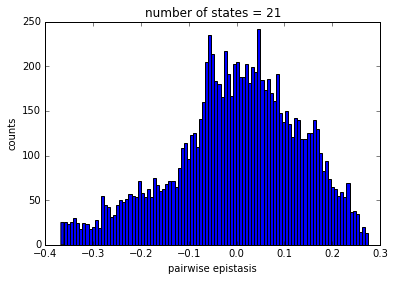

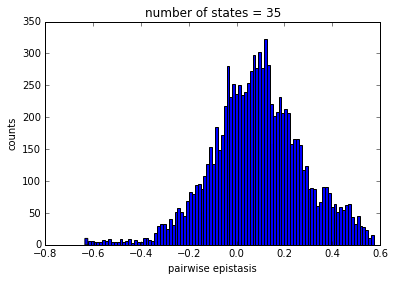

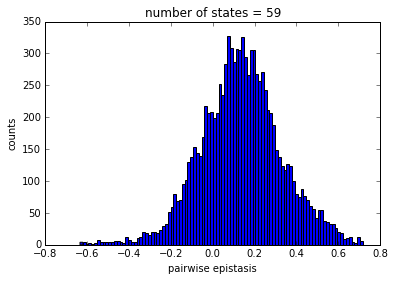

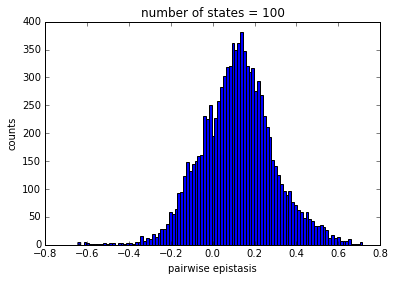

In [196]:
%matplotlib inline

num_bins = 100

for n in range(ns):
    plt.hist(true_ph_arr[n,:]-add_ph_arr[n,:],num_bins)
    plt.xlabel('pairwise epistasis')
    plt.ylabel('counts')
    plt.title('number of states = '+ str(num_states_arr[n]))
    plt.show()
